In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
##import and concatenate datasets
##Mac:
# path = r'/Users/asariversjulien/Documents/Data/CSV files/Sapelo/Yearly data'
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)

##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
#     print(df)

# df = df[df['Species_Code'] == 'A1'] ##eventually, you will want to do this

df

,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,B10,B11
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,NaN,NaN
1,0.0339,0.0488,0.0459,0.0952,0.0691,0.2915,0.0376,1,2,A1,...,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,NaN,NaN
2,0.0358,0.0578,0.0494,0.1039,0.0690,0.2920,0.0332,2,3,A1,...,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,NaN,NaN
3,0.0315,0.0393,0.0421,0.0773,0.0630,0.2920,0.0332,3,4,A1,...,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,NaN,NaN
4,0.0314,0.0533,0.0495,0.1394,0.1024,0.2911,0.0549,4,5,A1,...,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0193,0.0247,0.0397,0.0358,0.0885,0.0635,0.0347,172,4,A1,...,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,0.2977,0.2949
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,...,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,NaN,NaN
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,...,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,NaN,NaN
3214,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,175,6,A1,...,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,0.2980,0.2949


In [3]:
##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

##IMPORTANT: again, these bands between landsat 5 and 8 may not be able to be compared directly

##Variables from Byrd et al. 2018 (make sure calculations are accurate):
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df)

,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,Red_band,NIR_band,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,0.0309,0.0551,0.0357,0.0289,0.061945,-0.057314,0.013115,0.052448,-0.311905,-0.033445
1,0.0339,0.0488,0.0459,0.0952,0.0691,0.2915,0.0376,1,2,A1,...,0.0459,0.0952,0.0691,0.0376,0.115349,0.018182,-0.030623,0.180169,-0.433735,-0.099401
2,0.0358,0.0578,0.0494,0.1039,0.0690,0.2920,0.0332,2,3,A1,...,0.0494,0.1039,0.0690,0.0332,0.125134,0.025160,-0.078358,0.235043,-0.515682,-0.196126
3,0.0315,0.0393,0.0421,0.0773,0.0630,0.2920,0.0332,3,4,A1,...,0.0421,0.0773,0.0630,0.0332,0.085244,-0.042724,0.034398,0.110169,-0.399095,-0.118194
4,0.0314,0.0533,0.0495,0.1394,0.1024,0.2911,0.0549,4,5,A1,...,0.0495,0.1394,0.1024,0.0549,0.195747,0.169463,-0.036965,0.258560,-0.434894,0.051724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0193,0.0247,0.0397,0.0358,0.0885,0.0635,0.0347,172,4,A1,...,0.0358,0.0885,0.0635,0.0347,0.126622,0.105559,-0.051656,0.232919,-0.436688,-0.015603
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3214,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,175,6,A1,...,0.0484,0.0789,0.0530,0.0265,0.072932,-0.101878,-0.047244,0.165389,-0.497154,-0.292390


<AxesSubplot:xlabel='vp', ylabel='Plant_Biomass'>

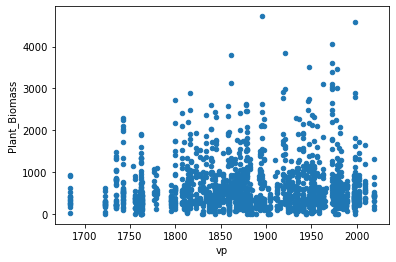

In [88]:
g = df1.plot(kind = 'scatter', x = 'prcp', y = 'Plant_Biomass')

g

# for col in df.columns:
#     print(col)

In [36]:
##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

display(dm)

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp'})

display(dm2)

,dayl,prcp,srad,swe,tmax,tmin,vp,system:index,Site,Species_Code,Year,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,ident
0,43200.085938,2.568438,342.593597,0.0,25.048056,14.132274,1776.901489,0,1,A1,2000,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,-0.387345
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,A1,2000,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,-0.387918
2,43200.085938,2.319699,336.004730,0.0,24.539864,15.079507,1874.970703,2,3,A1,2000,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,-0.388026
3,43200.085938,2.472329,340.215027,0.0,24.868795,14.635425,1827.156250,3,4,A1,2000,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,-0.386548
4,43200.085938,2.445726,340.010864,0.0,24.818274,14.757424,1839.845947,4,5,A1,2000,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,-0.386478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,43219.992188,3.616016,331.420837,0.0,26.539396,16.000111,1951.389526,172,4,A1,2019,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,-0.386540
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,2019,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,-0.387916
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,2019,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,-0.387919
3214,43219.945312,3.418571,331.718445,0.0,26.426649,16.417061,1985.196167,175,6,A1,2019,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,-0.386172


,sn_dayl,sn_prcp,sn_srad,swe,sn_tmax,sn_tmin,sn_vp,system:index,Site,Species_Code,Year,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,ident
0,43200.085938,2.568438,342.593597,0.0,25.048056,14.132274,1776.901489,0,1,A1,2000,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,-0.387345
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,A1,2000,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,-0.387918
2,43200.085938,2.319699,336.004730,0.0,24.539864,15.079507,1874.970703,2,3,A1,2000,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,-0.388026
3,43200.085938,2.472329,340.215027,0.0,24.868795,14.635425,1827.156250,3,4,A1,2000,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,-0.386548
4,43200.085938,2.445726,340.010864,0.0,24.818274,14.757424,1839.845947,4,5,A1,2000,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,-0.386478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,43219.992188,3.616016,331.420837,0.0,26.539396,16.000111,1951.389526,172,4,A1,2019,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,-0.386540
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,2019,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,-0.387916
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,2019,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,-0.387919
3214,43219.945312,3.418571,331.718445,0.0,26.426649,16.417061,1985.196167,175,6,A1,2019,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,-0.386172


In [46]:
##Merging elevation point data with band dataset prior to model development

elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

# elev_10m = elev_10m.drop_duplicates(subset=['Latitude'])

print(elev_10m.groupby(['Latitude','Longitude']).size())

print(len(df['Latitude'].unique()))
print(len(df['Longitude'].unique()))
print(len(elev_10m['Latitude'].unique()))
print(len(elev_10m['Longitude'].unique()))

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude'] ##Weird work around, but it works - check df comparison excel sheet

df['ident'] = df['Latitude']/df['Longitude'] ##Look at merging on multiple columns to test this

##Rationale on the 'ident' column: there are 208 unique lat/long combinations (ie locations), yet only 203 unique lats and \
##longs (some repeat, but no repeat combinations!). This 'ident' identifies unique combinations of lats and longs and can \
##be used to merge/sort the dataframes accordingly. To confirm the results, look at df_comparison excel sheet (in onedrive)

## print latest dataframe
# display(dfx)

print(len(dfx['Latitude'].unique()))
print(len(dfx['Longitude'].unique()))
print(len(dfx['ident'].unique()))
print(len(df['ident'].unique()))

# print(elev_10m)
# print(dfx)

df0 = pd.merge(df, dfx, on = 'ident') ##seems to work; check out comparison excel sheet
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

display(df1)
# display(df0)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'df0x.csv')
# df0x.to_csv(out_csv, index = False)

# for col in dfx.columns:
#     print(col)

Latitude   Longitude 
31.307529  -81.415324    20
31.307562  -81.415389    19
31.307641  -81.415468    19
31.307682  -81.415608    14
31.307693  -81.415592     5
                         ..
31.539429  -81.422410    19
31.539457  -81.422250    19
31.539480  -81.422098    19
31.539491  -81.421750    19
31.539505  -81.421937    19
Length: 208, dtype: int64
203
203
203
203
203
203
208
208


,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,sn_tmin,sn_vp,Latitude,Longitude,dayl,prcp,srad,tmax,tmin,vp
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,14.132274,1776.901489,31.538627,-81.422539,43200.085938,2.568438,342.593597,25.048056,14.132274,1776.901489
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0,1,A1,...,14.795082,1762.035522,31.538627,-81.422539,43220.082031,2.596593,342.510712,25.575659,14.795082,1762.035522
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,A1,...,15.120659,1892.155762,31.538627,-81.422539,43220.082031,3.840604,335.109985,25.630302,15.120659,1892.155762
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0,1,A1,...,14.338548,1778.461426,31.538627,-81.422539,43200.085938,3.297945,340.148438,25.406548,14.338548,1778.461426
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0,1,A1,...,14.206429,1799.670776,31.538627,-81.422539,43220.082031,4.259862,338.359924,25.079752,14.206429,1799.670776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0276,0.0341,0.0453,0.0418,0.0864,0.0560,0.0294,171,6,A1,...,16.611759,2019.184692,31.388000,-81.279858,43219.945312,3.738269,330.129822,26.283407,16.611759,2019.184692
3212,0.0249,0.0324,0.0492,0.0432,0.0930,0.0676,0.0334,166,6,A1,...,16.008654,2002.115845,31.388000,-81.279858,43219.945312,3.758626,326.138000,25.613874,16.008654,2002.115845
3213,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,175,6,A1,...,16.417061,1985.196167,31.388000,-81.279858,43219.945312,3.418571,331.718445,26.426649,16.417061,1985.196167
3214,0.0468,0.0489,0.0573,0.0643,0.1862,0.1990,0.1136,113,8,A3,...,15.542802,1946.075684,31.308979,-81.415683,43219.898438,3.972225,327.009491,25.753296,15.542802,1946.075684


In [89]:
##First go at machine learning, using the methods of Byrd et al 2018

##Need (from table 3)=: SAVI, normalized difference green/blue index, wide dynamic range vegetation index 5, ndvi red/green, \
##  ndvi swir2/nir, ndvi swir2/red, site? (site may be important when combining GA, VA, and MA data)

##Random Forest test! REMEMBER: by combining landsat 5 and 8 bands, you are grouping bands with slightly different wavelengths. 
##ONLY INDICES to account for this

##From: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp', 'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp']]

##From linear regression results: maybe remove nd_swir2_nir/r from feature list? May improve prediction results. 
##Also: nd_r_g, dayl, and vp all can be removed. Seasonal average vs. yearly average will probably be a choice.

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

## Feature Scaling - is this necessary? MIGHT VERY WELL BE - GET FEATURES INTO COMMON SCALE

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# xargs_train = sc.fit_transform(xargs_train)
# xargs_test = sc.transform(xargs_test)

from sklearn.ensemble import RandomForestRegressor ##try KNN next!

reg_x=RandomForestRegressor(n_estimators=100, random_state = 0) ##play with random state

##Train the model using the training sets y_pred=clf.predict(xargs_test)
reg_x.fit(xargs_train, yargs_train)
y_pred=reg_x.predict(xargs_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))

r_square = metrics.r2_score(yargs_test, y_pred)
print(r_square)
print(reg_x.score(xargs_test, yargs_test))


Mean Absolute Error: 280.69475669617293
Mean Squared Error: 173349.4845167698
Root Mean Squared Error: 416.3525963852871
0.46191933544082475
0.46191933544082475


In [60]:
# TODO

# Baselines:
# - always predict the mean biomass - compare to prediction from models
# - linear regression (done) (with scikit tools; in order to single out variable)
# - PCA in pipeline
# - means/sd with different 
# - KNN regressor: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# - Treat as classification for new model
# - Error metrics for telling how well the model works
# - Cross validation: leave one group out (LOGO) - look this up - be careful with nearest neighbor and grouping by site
# - LOGO: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

Mean Absolute Error: 280.7538039611452
Mean Squared Error: 169598.7742642092
Root Mean Squared Error: 411.82371746198544
The r squared is: 0.4735616236823653
0.4735616236823653
testing r2 is: 0.4735616236823653
training r2 is: 0.9080226653988586
NRMSE is: 0.10866978675296739
MEAN BASELINE:
Mean Absolute Error: 417.33870202925925
Root Mean Squared Error: 568.2708331812958


In [49]:
# plt.scatter(xargs,yargs, color='red') ##plotting real points
df['Plant_Biomass'].describe()

count    3216.000000
mean      754.379802
std       695.243694
min         0.000000
25%       306.861000
50%       540.702000
75%       959.620000
max      7189.432000
Name: Plant_Biomass, dtype: float64

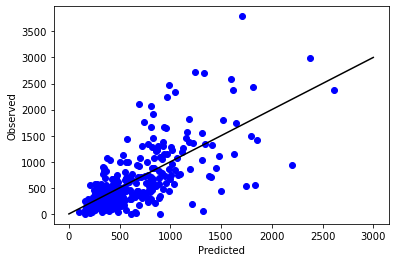

test data correlation coefficient is: 0.6886046911281519
train data correlation coefficient is: 0.9636055887375489


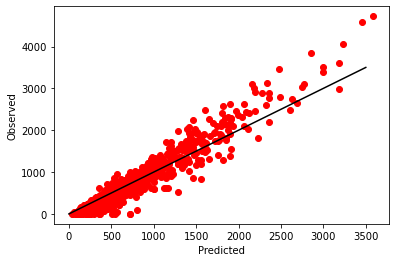

In [50]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = reg_x.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

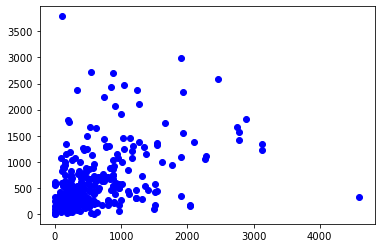

0.40057482860766996

In [68]:
plt.scatter(y_xg_pred, y_xg_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.show()

np.corrcoef(y_xg_test, y_xg_pred)[0, 1]

In [62]:
##k-fold cross validation; similar to original random forest regression code

predictors = df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp', 'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp']]
targets = df1['Plant_Biomass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = reg_x
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([0.90684772, 0.92437577, 0.90722346, 0.91708446, 0.90190029]),
 'score_time': array([0.01109648, 0.01209068, 0.01115656, 0.01110911, 0.01106381]),
 'test_r2': array([0.42303396, 0.45773922, 0.38556264, 0.44186379, 0.37823142]),
 'test_neg_root_mean_squared_error': array([-386.84480719, -482.65831676, -535.69341277, -416.08675343,
        -434.85984639])}

In [63]:
##Comparing with standard empirical model -- just uncomment and run

##sklearn - linear_regressor L1 weights look at these

print(len(xargs))
print(len(yargs))

print(xargs.head())

from sklearn import linear_model
import statsmodels.api as sm

regr = linear_model.LinearRegression()
regr.fit(xargs, yargs)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
xargs = sm.add_constant(xargs) ##adding a constant
 
model = sm.OLS(yargs, xargs).fit()
predictions = model.predict(xargs) 
 
print_model = model.summary()
print(print_model) ##check model assumptions

1626
1626
       ndvi  nd_swir2_r  nd_swir2_nir    nd_g_b    nd_r_g    wdrvi5      savi  \
0  0.281395   -0.033445     -0.311905  0.052448  0.013115 -0.057314  0.061945   
1  0.359489    0.121402     -0.248952  0.211394 -0.070199  0.029717  0.096949   
3  0.361775   -0.016304     -0.375862  0.109961 -0.068493  0.032342  0.103046   
4  0.461861   -0.019048     -0.476715  0.201331 -0.058651  0.151915  0.133457   
5  0.291521    0.002453     -0.289275  0.022876 -0.012945 -0.046312  0.112020   

   Elevation      prcp          dayl       tmax       tmin        srad  \
0   0.489376  2.568438  43200.085938  25.048056  14.132274  342.593597   
1   0.489376  2.596593  43220.082031  25.575659  14.795082  342.510712   
3   0.489376  3.297945  43200.085938  25.406548  14.338548  340.148438   
4   0.489376  4.259862  43220.082031  25.079752  14.206429  338.359924   
5   0.489376  2.628269  43220.082031  26.066071  14.187940  351.314453   

            vp   sn_prcp       sn_dayl    sn_tmax    sn_tm

In [14]:
##Some more plots

# sorted(sklearn.metrics.SCORERS.keys())

In [64]:
##xgboost - seems to perform worse than random forest, at least with initial data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## split data into X and y
xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp', 'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp']]
yargs=df1['Plant_Biomass'] 

## split data into train and test sets
size_x = 0.2
seed = 0
x_xg_train, x_xg_test, y_xg_train, y_xg_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed)

##Feature Scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_xg_train = sc.fit_transform(x_xg_train)
x_xg_test = sc.transform(x_xg_test)

##fit model no training data
xg_reg = XGBClassifier()
xg_reg.fit(x_xg_train, y_xg_train)

##make predictions for test data
y_xg_pred = xg_reg.predict(x_xg_test)
# predictions = [round(value) for value in y_pred]

##evaluate predictions

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_xg_test, y_xg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_xg_test, y_xg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_xg_test, y_xg_pred)))

r_square = metrics.r2_score(y_xg_test, y_xg_pred)
print(r_square)
# print(reg_x.score(x_xg_test, y_xg_test))

# accuracy = accuracy_score(yargs_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Absolute Error: 398.1685398773006
Mean Squared Error: 414247.34623263805
Root Mean Squared Error: 643.6204986112841
-0.2858329978545133


In [31]:
print(len(xargs_test))
print(len(xargs_train))


326
1300


RMSE value for k=  1 is: 591.9363279925059
RMSE value for k=  2 is: 517.2568305710352
RMSE value for k=  3 is: 491.51294204320254
RMSE value for k=  4 is: 483.42482922551125
RMSE value for k=  5 is: 486.8517867160917
RMSE value for k=  6 is: 482.65730320380385
RMSE value for k=  7 is: 490.986855568187
RMSE value for k=  8 is: 482.98692731662317
RMSE value for k=  9 is: 492.641221892248
RMSE value for k=  10 is: 496.7933485593652
RMSE value for k=  11 is: 500.3545907159674
RMSE value for k=  12 is: 499.9235940374949
RMSE value for k=  13 is: 496.7778033237526
RMSE value for k=  14 is: 496.40765822542755
RMSE value for k=  15 is: 491.9886790050044
RMSE value for k=  16 is: 492.26127488500146
RMSE value for k=  17 is: 490.8954118507526
RMSE value for k=  18 is: 488.73386945321363
RMSE value for k=  19 is: 487.78188743851166
RMSE value for k=  20 is: 487.70237451491596


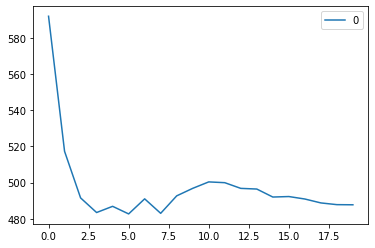

In [65]:
##KNN - be careful of site bias!! Data are spatially clustered based on site, also temporally clustered based on year

##Careful of overlap in variable names!

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here

from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

k_xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
           'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp', 'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp']]

##Include lag variables (e.g. lag ndvi), precip, temp, more

k_yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0

k_xargs_train, k_xargs_test, k_yargs_train, k_yargs_test = \
train_test_split(k_xargs, k_yargs, test_size=size_x, random_state = seed)

## 80% training and 20% test

## Feature Scaling - does something weird with k values, what does that mean? Use minmax scaler instead (below), as in example?
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# xargs_train = sc.fit_transform(xargs_train)
# xargs_test = sc.transform(xargs_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
k_xargs_train = scaler.fit_transform(k_xargs_train)
k_xargs_test = scaler.fit_transform(k_xargs_test)

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    k_model = neighbors.KNeighborsRegressor(n_neighbors = K)

    k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
    k_pred=k_model.predict(k_xargs_test) #make prediction on test set
    k_error = sqrt(mean_squared_error(k_yargs_test, k_pred)) #calculate rmse
    rmse_val.append(k_error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', k_error)
    
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot() 

k_predict = k_model.predict(k_xargs_test)
##from: https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/


RMSE for KNN is: 482.65730320380385


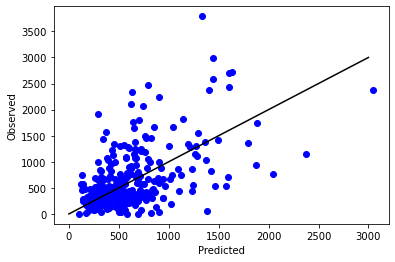

test data correlation coefficient is: 0.5471002679523634
train data correlation coefficient is: 0.7115669632506572


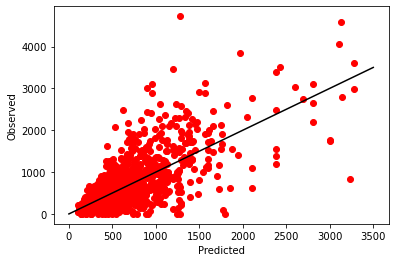

In [87]:
##KNN test results, plotted (careful of variable names overlap)
k_model = neighbors.KNeighborsRegressor(n_neighbors = 6)
k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
k_pred=k_model.predict(k_xargs_test) #make prediction on test set
k_error = sqrt(mean_squared_error(k_yargs_test, k_pred))
print('RMSE for KNN is: ' + str(k_error))

plt.scatter(k_pred, k_yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(k_yargs_test, k_pred)[0, 1]))

k_train_pred = k_model.predict(k_xargs_train) 
plt.scatter(k_train_pred, k_yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(k_train_pred, k_yargs_train)[0, 1]))

##Odd that the training data is not better